[![DOI](https://zenodo.org/badge/940091341.svg)](https://doi.org/10.5281/zenodo.14939868) <a href="https://www.globh2e.org.au/"><img src="https://img.shields.io/badge/ARC:Funding%20number-IC200100023-blue.svg"/></a>

# **Integrated Assessment model scenario analysis**
<!-- **<div style="text-align: left; font-size: 19px;"> Scenario analysis**</div> -->

<div style="text-align: left; font-size: 16px;">Michaël Lejeune<sup>a,b</sup>, Sami Kara<sup>a,b</sup>, Michael Zwicky Hauschild<sup>c,d</sup>, Sareh Sharabifarahni<sup>a</sup>, Rahman Daiyan<sup>b,e</sup></div><br>

<div style="text-align: left; font-size: 13px;"><sup>a</sup>Sustainability in Manufacturing and Life Cycle Engineering Research Group, School of Mechanical and Manufacturing Engineering, the University of New South Wales, 2052, Sydney, Australia</div>

<div style="text-align: left; font-size: 13px;">
<sup>b</sup>Australian Research Council Training Centre for the Global Hydrogen Economy (GlobH2e), the University of New South Wales, 2052, Sydney, Australia</div>

<div style="text-align: left; font-size: 13px;">
<sup>c</sup>Centre for Absolute Sustainability, Technical University of Denmark, Kgs, Lyngby, Denmark</div>

<div style="text-align: left; font-size: 13px;">
<sup>d</sup>Division for Quantitative Sustainability Assessment (QSA), Department of Environmental and Resource Engineering, Technical University of Denmark, Kgs, Lyngby, Denmark</div>

<div style="text-align: left; font-size: 13px;">
<sup>e</sup>School of Minerals and Energy Engineering, The University of New South Wales, Sydney 2052, Australia</div><br>

<div style="text-align: left; font-size: 13px;"> Code developer and maintainer:<a href="mailto:m.lejeune@unsw.edu.au"> Michaël Lejeune</div></a><br>


In [1]:
using CSV,DataFrames,XLSX,Statistics
using LinearAlgebra,SparseArrays
using JLD2
include("Utils/general_utils/config.jl");2
include("Utils/general_utils/ssp_utils.jl");


In [67]:
rcParams["axes.prop_cycle"] = plt.cycler("color",["#e32f27"
                                                "#fca082"
                                                "#3787c0"]);


In [55]:
SSP1 = CSV.read(scenario_path*"SSP1-remind.csv", DataFrame)
SSP2 = CSV.read(scenario_path*"SSP2-remind.csv", DataFrame)
SSP5 = CSV.read(scenario_path*"SSP5-remind.csv", DataFrame)
SSP11 = CSV.read(scenario_path*"SSP1-remind1150.csv", DataFrame)
SSP21 = CSV.read(scenario_path*"SSP2-remind1150.csv", DataFrame)
SSP51 = CSV.read(scenario_path*"SSP5-remind1150.csv", DataFrame)
SSP=vcat(SSP1, SSP2, SSP5)#, SSP11, SSP21, SSP51);
years = parse.(Int, names(SSP)[findfirst(==("2020"), names(SSP)):findfirst(==("2100"), names(SSP))]);


In [4]:
# pth="../data/data_planetaryboundaries/"
# SSP1 = CSV.read(pth*"SSP1.csv", DataFrame)
# SSP2 = CSV.read(pth*"SSP2_19_Sus.csv", DataFrame)
# SSP5 = CSV.read(pth*"SSP2_19.csv", DataFrame)
# SSP=vcat(SSP1, SSP2, SSP5);
# years = parse.(Int, names(SSP)[findfirst(==("2020"), names(SSP)):findfirst(==("2100"), names(SSP))]);


In [5]:
# se=get_vals("Secondary Energy")|> Matrix
# se_f = [ isa(x, AbstractString) ? parse(Float64, x) :
#          isa(x, Number)         ? Float64(x)       :
#          missing
#        for x in se ]
# se_f = reshape(se_f, size(se))
# se_f[:,1:6]


In [6]:
# plot_var(Matrix(se_f[:,2:7]'))


In [116]:
SEH2=get_vals("SE|Hydrogen");
EJ_kWh= 1/3.6e-12 #kWh/EJ
LHVH2=33.33 # kWh/kgH2
EJH2_to_kgH2=EJ_kWh/LHVH2 # kWh/EJ * kgH2/kWh = kgH2/EJ

SEH2=get_vals("SE|Hydrogen") #EJ
TotalkgH2=SEH2.*EJH2_to_kgH2 # EJ * kgH2/EJ = kgH2

TotalMtH2=TotalkgH2.*1e-9 # mass H2 to MtH2
TotalGtH2=TotalkgH2.*1e-12 # mass H2 to GtH2
;


## ***3.2 Constraints***

### ***3.2.1. Electricity***

Here we can check the efficiency the models expect for water electrolysis. But this cannot be implemented easily. We rather focus on efficiency gains which can be adapted to our case study. 

In [59]:
Matrix(get_vals("SE|Input|Electricity|Hydrogen").*EJ_kWh)./(get_vals("SE|Hydrogen|+|Electricity").*EJH2_to_kgH2)


Row,2025,2030,2035,2040,2045,2050
,Float64,Float64,Float64,Float64,Float64,Float64
1,52.9048,51.2769,49.7463,48.3043,46.9437,45.6575
2,52.9048,51.2769,49.7463,48.3043,46.9437,45.6575
3,52.9048,51.2769,49.7463,48.3043,46.9437,45.6575


In [60]:
𝛈_electrolysis_raw=get_vals("Tech|Hydrogen|Electricity|Efficiency")


Row,2025,2030,2035,2040,2045,2050
,Float64,Float64,Float64,Float64,Float64,Float64
1,63.0,65.0,67.0,69.0,71.0,73.0
2,63.0,65.0,67.0,69.0,71.0,73.0
3,63.0,65.0,67.0,69.0,71.0,73.0


In [61]:
𝛈_electrolysis=Matrix((𝛈_electrolysis_raw./𝛈_electrolysis_raw[:,1]))


3×6 Matrix{Float64}:
 1.0  1.03175  1.06349  1.09524  1.12698  1.15873
 1.0  1.03175  1.06349  1.09524  1.12698  1.15873
 1.0  1.03175  1.06349  1.09524  1.12698  1.15873

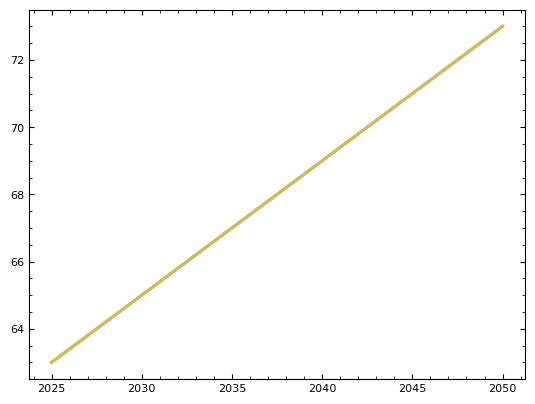

In [62]:
𝛈_electrolysis_raw=get_vals("Tech|Hydrogen|Electricity|Efficiency")
plt.plot(2025:5:2050,Matrix(𝛈_electrolysis_raw)',linewidth=2)
plt.legend(frameon=false)
display(plt.gcf())
plt.close("all")


In [63]:
𝛈_electrolysis_raw=get_vals("Tech|Hydrogen|Electricity|Efficiency")
𝛈_electrolysis=(𝛈_electrolysis_raw./𝛈_electrolysis_raw[:,1])




Row,2025,2030,2035,2040,2045,2050
,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,1.03175,1.06349,1.09524,1.12698,1.15873
2,1.0,1.03175,1.06349,1.09524,1.12698,1.15873
3,1.0,1.03175,1.06349,1.09524,1.12698,1.15873


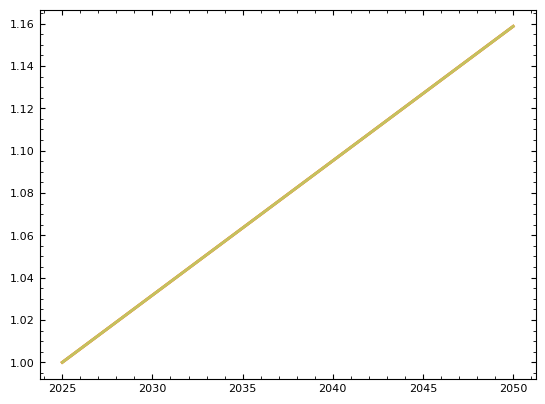

In [64]:
plt.plot(2025:5:2050,Matrix(𝛈_electrolysis)',linewidth=2)
plt.legend(frameon=false)
display(plt.gcf())
plt.close("all")


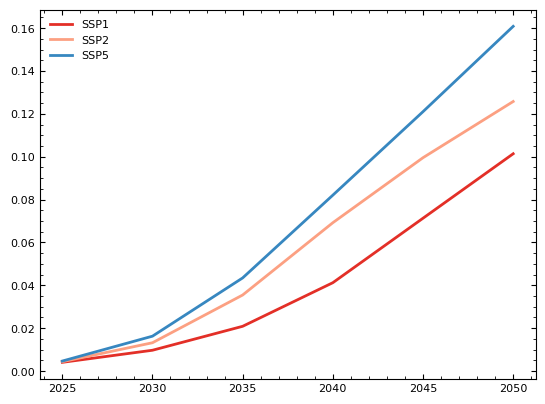

In [120]:
share=get_vals("SE|Hydrogen")./get_vals("SE")
plt.plot(2025:5:2050,Matrix(share)',label=["SSP1","SSP2", "SSP5",
],linewidth=2)
plt.legend(frameon=false)
display(plt.gcf())
plt.close("all")


In [69]:
c_biomass_electricity= Matrix(get_vals("SE|Electricity|+|Biomass").*EJ_kWh./TotalkgH2.*share)'
c_gas_electricity= Matrix(get_vals("SE|Electricity|+|Gas").*EJ_kWh./TotalkgH2.*share)'
c_gas_electricity_CC = Matrix(get_vals("SE|Electricity|Gas|+|w/ CC").*EJ_kWh./TotalkgH2.*share)'
c_gas_electricity_noCC = Matrix(get_vals("SE|Electricity|Gas|+|w/o CC").*EJ_kWh./TotalkgH2.*share)'
c_coal_electricity= Matrix(get_vals("SE|Electricity|+|Coal").*EJ_kWh./TotalkgH2.*share)'
c_oil_electricity = Matrix(get_vals("SE|Electricity|Oil|w/o CC").*EJ_kWh./TotalkgH2.*share)'
c_geothermal_electricity= Matrix(get_vals("SE|Electricity|+|Geothermal").*EJ_kWh./TotalkgH2.*share)'
c_hydro_electricity= Matrix(get_vals("SE|Electricity|+|Hydro").*EJ_kWh./TotalkgH2.*share)'
c_nuclear_electricity= Matrix(get_vals("SE|Electricity|+|Nuclear").*EJ_kWh./TotalkgH2.*share)'
c_wind_electricity= Matrix(get_vals("SE|Electricity|+|Wind").*EJ_kWh./TotalkgH2.*share)'
c_solar_electricity= Matrix(get_vals("SE|Electricity|+|Solar").*EJ_kWh./TotalkgH2.*share)'
c_solar_PV_electricity= Matrix(get_vals("SE|Electricity|Solar|+|PV").*EJ_kWh./TotalkgH2.*share)'
c_CSP_electricity = Matrix(get_vals("SE|Electricity|Solar|+|CSP").*EJ_kWh./TotalkgH2.*share)'
;


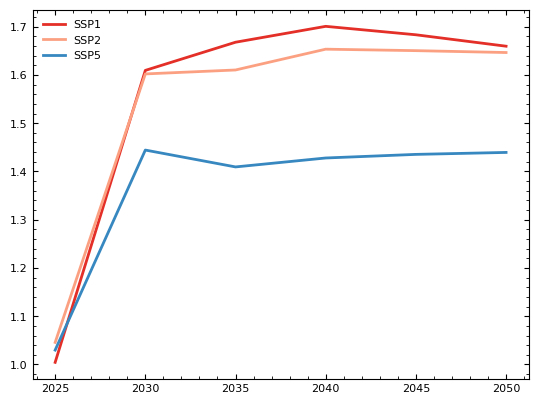

In [73]:
r_solar_wind=(c_solar_electricity./c_wind_electricity)

plt.plot(2025:5:2050,Matrix(r_solar_wind),label=["SSP1","SSP2", "SSP5"],linewidth=2)
plt.legend(frameon=false)
display(plt.gcf())
plt.close("all")


### ***3.1.1. electrolysis technology ratios***

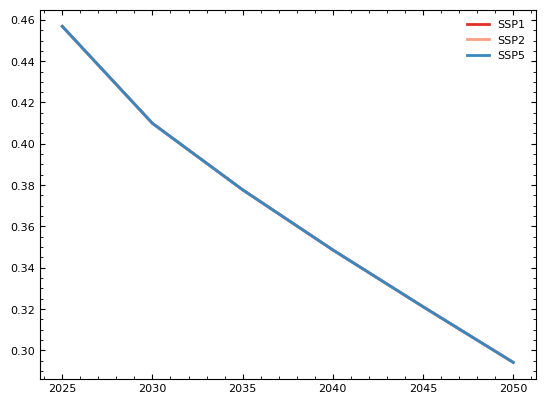

In [ ]:
plt.plot(2025:5:2050,Matrix(C_AEC),label=["SSP1","SSP2", "SSP5"],linewidth=2)
plt.legend(frameon=false)
display(plt.gcf())
plt.close("all")


In [18]:
C_AEC= [0.456858911	0.409911702	0.377745893	0.348652174	0.321172296	0.294236939
        0.456858911	0.409911702	0.377745893	0.348652174	0.321172296	0.294236939
        0.456858911	0.409911702	0.377745893	0.348652174	0.321172296	0.294236939]'|>Matrix;


In [19]:
C_PEM=[0.482496124	0.519686209	0.544879587	0.565652714	0.584064837	0.601662915
        0.482496124	0.519686209	0.544879587	0.565652714	0.584064837	0.601662915
        0.482496124	0.519686209	0.544879587	0.565652714	0.584064837	0.601662915]'|>Matrix;



In [20]:
C_SOEC=[0.060644965	0.070402088	0.077374519	0.085695112	0.094762867	0.104100147
        0.060644965	0.070402088	0.077374519	0.085695112	0.094762867	0.104100147
        0.060644965	0.070402088	0.077374519	0.085695112	0.094762867	0.104100147]'|>Matrix;



### ***3.1.3. Hydrogen production***

In [21]:
c_gas= Matrix(get_vals("SE|Hydrogen|Gas|+|w/o CC").*EJH2_to_kgH2./TotalkgH2)'|>Matrix
c_gasccs= Matrix(get_vals("SE|Hydrogen|Gas|+|w/ CC").*EJH2_to_kgH2./TotalkgH2)'|>Matrix
c_biomass= Matrix(get_vals("SE|Hydrogen|Biomass|+|w/o CC").*EJH2_to_kgH2./TotalkgH2)'|>Matrix
c_biomassccs= Matrix(get_vals("SE|Hydrogen|Biomass|+|w/ CC").*EJH2_to_kgH2./TotalkgH2)'|>Matrix
c_coal= Matrix(get_vals("SE|Hydrogen|Coal|+|w/o CC").*EJH2_to_kgH2./TotalkgH2)'|>Matrix
c_coalccs= Matrix(get_vals("SE|Hydrogen|Coal|+|w/ CC").*EJH2_to_kgH2./TotalkgH2)'|>Matrix
c_electrolysis= Matrix(get_vals("SE|Hydrogen|+|Electricity").*EJH2_to_kgH2./TotalkgH2)'|>Matrix


6×6 Matrix{Float64}:
 0.181111  0.186027  0.223208  0.110357   0.0931152  0.115706
 0.327035  0.390087  0.47818   0.0700298  0.116238   0.127506
 0.397655  0.372138  0.45914   0.059081   0.304339   0.253314
 0.437081  0.344218  0.456027  0.181549   0.609637   0.429342
 0.534109  0.392171  0.524074  0.510546   0.825793   0.524677
 0.637826  0.482595  0.631777  0.807822   0.916884   0.596942

# Export to a JLD file

In [22]:
constraintsPath=mkpath(respath*"constraints")


UndefVarError: UndefVarError: `respath` not defined

In [23]:
@save constraintsPath*"/constraints_elec.jld" c_biomass_electricity c_gas_electricity c_gas_electricity_CC c_gas_electricity_noCC c_coal_electricity c_oil_electricity c_geothermal_electricity c_hydro_electricity c_nuclear_electricity c_wind_electricity c_solar_electricity c_solar_PV_electricity c_CSP_electricity

@save constraintsPath*"/constraints_h2.jld" c_biomass c_biomassccs c_gas c_gasccs c_coal c_coalccs c_electrolysis C_AEC C_PEM C_SOEC


UndefVarError: UndefVarError: `constraintsPath` not defined

## **2.2. Critical analysis using REMIND SSPx-PkBudg500 scenarios**
Here we perform a few preparatory calculations for hydrogen electrolysis efficiency and total hydrogen production:

1. We load the raw electricity‐to‐hydrogen conversion efficiencies (`η_electrolysis_raw`) from our data and normalize each column by its first value.  This gives us a matrix of relative efficiencies (`η_electrolysis`) for each scenario/time step.

2. We then retrieve the total hydrogen energy supply (`SEH2`) in exajoules (EJ).  

3. Using the fact that 1 EJ = 1/(3.6 × 10⁻¹²) kWh and the lower heating value of hydrogen (33.33 kWh/kg), we compute a conversion factor from EJ to kg of H₂ (`EJH2_to_kgH2`).

4. Multiplying the energy supply (EJ) by this factor gives the total hydrogen mass in kilograms (`TotalkgH2`).  

5. Finally, we express that mass in million tonnes (`TotalMtH2 = kg × 10⁻⁹`) and in billion tonnes (`TotalGtH2 = kg × 10⁻¹²`) for easy reporting.

In [25]:
# MWh_H2=get_vals("SE|Hydrogen").*(1/3.6e-9) #MWh/yr
# cf=0.6 # assumed capacity factor
# ((MWh_H2./(8760*cf))./1000)
# GW_Cap=((MWh_H2./(8760*cf))./1000)|> Matrix #capacity in GW
# ;
